In [2]:
from neo4j import GraphDatabase
import pandas as pd

## Construindo Grid de Cidades 

In [55]:
#Carregando dados de Município
df_municipios = pd.read_csv("../data/integrado/municipio.csv")
df_municipios= df_municipios[df_municipios['latitude'].notna()]

#Carregando dados de fluxo
df_fluxo = pd.read_csv("../data/calculado/fluxo_prob_qtd.csv")
df_fluxo = df_fluxo.drop_duplicates()
df_fluxo= df_fluxo[df_fluxo["cod_origem"].isin(df_municipios["cod_mun"])]
df_fluxo= df_fluxo[df_fluxo["cod_destino"].isin(df_municipios["cod_mun"])]


In [56]:
df_fluxo[df_fluxo["cod_origem"]==2803302]["total_pessoas"].sum()/365

13193.753424657534

In [5]:
#Criando dataframe com resultados
df_si = pd.DataFrame(df_municipios[["cod_mun", "populacao_2021"]])
df_si = df_si.set_index('cod_mun')

#Inicializa todos os municipios com 0 infectados
df_si["dia_0"] = 0.0

#Municipio Incial
municipio_zero = 5300108 #Brasilia
df_si.loc[municipio_zero,"dia_0"] = 1 #Somente a cidade zero possui infeccao

#Numero de dias a executar o modelo
nDias =  40

In [6]:
def conexoesCidade(df_fluxo, cidadeAtual):
    df_fluxo_saida = df_fluxo[df_fluxo["cod_origem"] == cidadeAtual]
    df_fluxo_entrada = df_fluxo[df_fluxo["cod_destino"] == cidadeAtual]

    listaCidades_1 = df_fluxo_saida["cod_destino"].tolist()
    listaCidades_2 = df_fluxo_entrada["cod_origem"].tolist()
    listaFinal =  set(listaCidades_1 + listaCidades_2)
    return listaFinal

In [7]:
#Encontrar as conexoes de todas as cidade
lista_mun = df_municipios["cod_mun"].tolist()
lista_conexoes = []
for cod_mun in lista_mun:
    lista_conexoes.append(conexoesCidade(df_fluxo, cod_mun))

df_si['conexoes'] = lista_conexoes

In [8]:
lista_mun = df_municipios["cod_mun"].tolist()

In [9]:
len(lista_mun)

5570

In [10]:
lista_mun = df_fluxo[df_fluxo["cod_origem"]==municipio_zero]["cod_destino"].tolist()
lista_mun.append(municipio_zero)

In [41]:
cidadeAtual = municipio_zero
r = .2  #Taxa de transmissão da doenca
s = 1 #Parametro livre usado pra corrigir superestimacao ou baixaextimacao das entradas e saidas da cidade
        
for dia in range(1, 30):
    infeccoesDia = []
    print(dia)
    # for cidadeAtual in lista_mun:
        # print(cidadeAtual)
        # existeProximaCidade  =  True
        # df_si[f"dia_{dia}"] = 0.0

        # while(existeProximaCidade):    

    N = df_si.loc[cidadeAtual,"populacao_2021"]#populacao do conjunto
    I = df_si.loc[cidadeAtual,f"dia_{dia-1}"] # Infectados na populacao

    #Valor da contaminacao interna
    dInterna = (r)*I*((N-I)/N)

    #Calculo do Valor da contaminacao externa
    #Fitrar todas as ligacoes que a cidade possui (Entrada e Saída de pessoas)
    df_fluxo_saida = pd.DataFrame(df_fluxo[df_fluxo["cod_origem"] == cidadeAtual]).set_index('cod_destino')
    df_fluxo_entrada = pd.DataFrame(df_fluxo[df_fluxo["cod_destino"] == cidadeAtual]).set_index('cod_origem')

    listaConexoes = df_si.loc[cidadeAtual,"conexoes"]

    somaEntrada = 0
    somaSaida = 0
    # for conexao in listaConexoes:

    #     #Verifica se há conexao de entrada
    #     if(conexao in df_fluxo_entrada.index):
    #         Nd = df_si.loc[conexao,"populacao_2021"] #Populacao da cidade vizinha
    #         Md = df_fluxo_entrada.loc[conexao, "total_pessoas"]/365 #Numero de pessoas entrando da outra cidade
    #         Id = df_si.loc[conexao,f"dia_{dia-1}"] # Numero de infectados da cidade vizinha
    #         somaEntrada += (Md/Nd)*Id

    #     #Verifica se há conexao de saída
    #     if(conexao in df_fluxo_saida.index):
    #         M = df_fluxo_saida.loc[conexao, "total_pessoas"]/365
    #         somaSaida += (M/N)*I
        
    dExterna = s*(somaEntrada - somaSaida)
    dExternaCorrigida = dExterna if dExterna>0 else 0
    dTotal = dInterna + dExternaCorrigida
    novoI = I + dTotal
    df_si.loc[cidadeAtual,f"dia_{dia}"] = novoI
    # print(novoI)
    # infeccoesDia.append(novoI) #
    # df_si[f"dia_{dia}"] = infeccoesDia #


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [43]:
df_si.loc[cidadeAtual][0:30]

populacao_2021                                            3094325.0
dia_0                                                           1.0
conexoes          {2603009, 2918407, 2103307, 4108304, 3502101, ...
dia_1                                                           1.2
dia_2                                                          1.44
dia_3                                                         1.728
dia_4                                                      2.073599
dia_5                                                      2.488319
dia_6                                                      2.985982
dia_7                                                      3.583178
dia_8                                                      4.299813
dia_9                                                      5.159775
dia_10                                                     6.191728
dia_11                                                     7.430071
dia_12                                          

Selecionando Municipio

C:\Users\mcso\AppData\Local\Temp\ipykernel_12032\1145480624.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


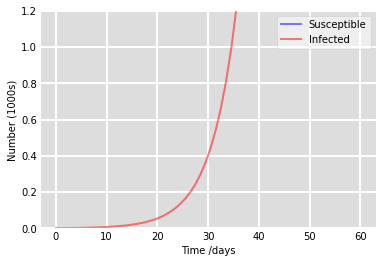

In [77]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Total population, N.
N = 85309
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 60, 60)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I = y
    dSdt = -beta * S * I / N   
    dIdt = beta * S * I / N 
    return dSdt, dIdt

# Initial conditions vector
y0 = S0, I0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
# ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [63]:
len(I)

60

In [79]:
I [28]

296.3222376159574

In [ ]:
1.0,1.2176999792497598,1.4827932339641168,1.8055972753750549,
2.1986757345746555,2.6773273416812677,3.2601813552258667,3.9699226157087564,
4.834174442118856,5.8865737332507635,7.168080115947365,8.728570091013383,
10.62877821890921,12.942660892992219,15.760274693473228,19.191281340168945,
23.369215645502756,28.456682559406275,34.651685549408555,42.19533257789797,
51.38121953544463,62.566856247100546,76.1875796230387,92.77349526135642,
112.9701065843069,137.56343396849593,167.5106008729362,203.97707643677484,
248.3820226316923,302.45350880562364

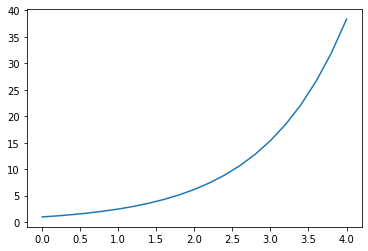

In [1]:
import numpy as np
import matplotlib.pyplot as plt

dt = 0.2
U0 = 1
T = 4
N = int(T/dt)
t = np.zeros(N+1)
u = np.zeros(N+1)
t[0] = 0
u[0] = U0
for n in range(N):
    t[n+1] = t[n] + dt
    u[n+1] = (1 + dt)*u[n]
plt.plot(t,u)
plt.show()

In [ ]:
df_fluxo = pd.read_csv("../data/calculado/fluxo_prob_qtd.csv")